In [47]:
# setup the environment
% matplotlib inline
import nengo
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import scipy.stats as st
from nengo.dists import UniformHypersphere

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("paper")

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

In [48]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# observed current age (i.e., t value)
x = 40

### Representation using subsapces and the Complete Model in Nengo


In [49]:
import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

In [50]:
# prior parameters
skew = -6 
loc = 99 
scale = 27 

# our function domain is thetas (i.e., age from 1 to 120)
thetas = np.linspace(start=1, stop=max_age, num=max_age)

def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

def skew_gauss(skew, loc, scale):
    return [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 
    
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    return post

def normalized_posterior(x, skew, loc, scale):
    post = posterior(x, skew, loc, scale)
    post = post/sum(post)
    return post  

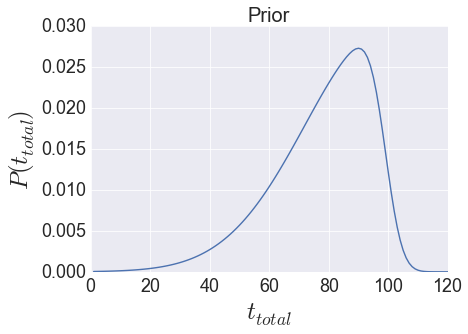

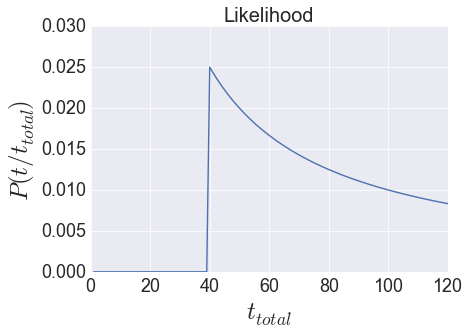

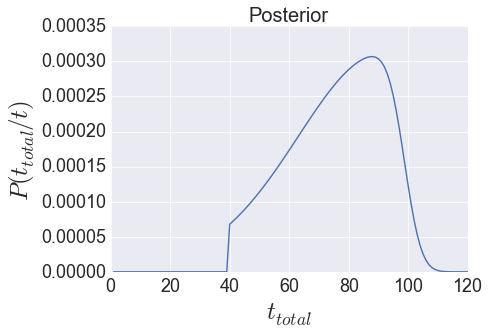

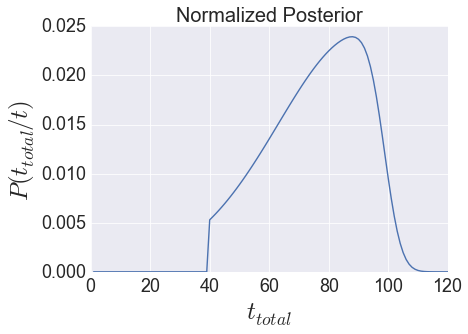

In [51]:
prior = skew_gauss(skew, loc, scale)
like = likelihood(x)
post_result = posterior(x, skew, loc, scale)
normalized_result = normalized_posterior(x, skew, loc, scale)

plt.figure()
plt.plot(thetas, prior)
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, like)
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, post_result)
plt.title("Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.figure()
plt.plot(thetas, normalized_result)
plt.title("Normalized Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

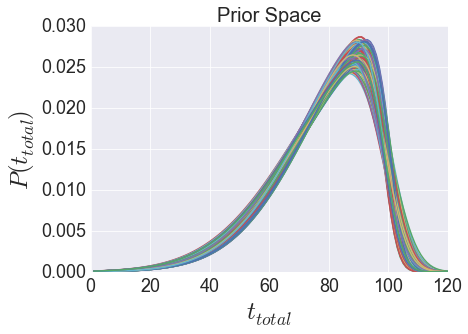

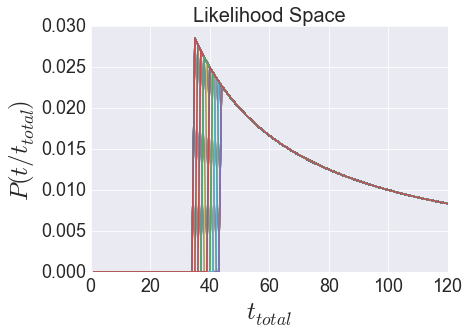

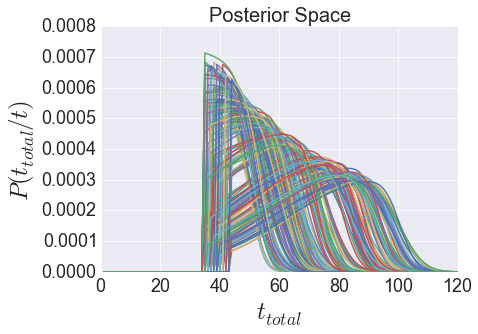

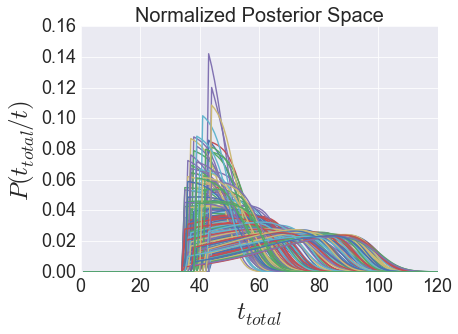

In [52]:
# DEFINE SUB-SPACES in Nengo
if x<5:
    pad = 5-x+1
else:
    pad = 0

n_basis = 20

space = nengo.FunctionSpace(
            nengo.dists.Function(skew_gauss,
                             skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-1, loc+2), 
                                                                                 
                          scale=nengo.dists.Uniform(scale-1, scale+2)),
            n_basis=n_basis)

from copy import deepcopy
space_raw = deepcopy(space.space)


data = space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Prior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)


lik_space = nengo.FunctionSpace(
                nengo.dists.Function(likelihood,
                            x=nengo.dists.Uniform(x-5+pad,x+5+pad)),
                n_basis=n_basis)

lik_space_raw = deepcopy(lik_space.space)

data = lik_space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.plot(thetas, likelihood(x=x))
plt.title("Likelihood Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)



post_space = nengo.FunctionSpace(
                nengo.dists.Function(posterior,
                             x=nengo.dists.Uniform(x-5+pad,x+5+pad),
                            skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-50, loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2)),
                n_basis=n_basis)

post_space_raw = deepcopy(post_space.space)


data = post_space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Posterior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)


norm_post_space = nengo.FunctionSpace(
                nengo.dists.Function(normalized_posterior,
                             x=nengo.dists.Uniform(x-5+pad,x+5+pad),
                            skew=nengo.dists.Uniform(skew-1, skew+2), 
                          loc=nengo.dists.Uniform(loc-50, loc+2), 
                          scale=nengo.dists.Uniform(scale-1, scale+2)),
                n_basis=n_basis)

norm_post_space_raw = deepcopy(norm_post_space.space)


data = norm_post_space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Normalized Posterior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.show()


In [60]:
k = np.zeros((120, n_basis))    # post basis for reconstruction     
j = 0
for element in space.basis.T:
        a = np.multiply(element, lik_space.basis.T[j])
        k[:, j] = a #np.sqrt(np.abs(a)) * np.sign(a)
        j = j + 1        

post_space._basis = k

model = nengo.Network()
#model.config[nengo.Ensemble].neuron_type=#nengo.Direct() #nengo.LIFRate() 
with model:
    stim = nengo.Node(label="prior input", output=space.project(skew_gauss(skew=skew, loc=loc, scale=scale)))
    ens = nengo.Ensemble(label="Prior", n_neurons=200, dimensions=space.n_basis,
                         encoders=space.project(space_raw),
                         eval_points=space.project(space_raw),
                        )
    
    stim2 = nengo.Node(label="likelihood input", output=lik_space.project(likelihood(x=x)))
    ens2 = nengo.Ensemble(label="Likelihood", n_neurons=200, dimensions=lik_space.n_basis,
                         encoders=lik_space.project(lik_space_raw),
                         eval_points=lik_space.project(lik_space_raw),
                        )
    
    nengo.Connection(stim, ens)
    probe_func = nengo.Probe(ens, synapse=0.03)
    
    nengo.Connection(stim2, ens2)
    probe_func2 = nengo.Probe(ens2, synapse=0.03)
    
    # elementwise multiplication
    post = nengo.Ensemble(label="Posterior", n_neurons=200, dimensions=post_space.n_basis,
                              neuron_type=nengo.Direct())
    
    product = nengo.networks.Product(n_neurons=50*2, dimensions=post_space.n_basis, input_magnitude=1)

    nengo.Connection(ens, product.A)
    nengo.Connection(ens2, product.B)
    nengo.Connection(product.output, post)

    probe_func3 = nengo.Probe(post, synapse=0.03)
    probe_product = nengo.Probe(product.output, synapse=0.03)

    
    # normalization
    def normalize(a):
        b = np.dot(a, k.T)  # reconstructing in the resulting post space
        total = np.abs(np.sum(b))
        if total == 0:
            return [0]*dim
        return b/total
    
           
    from nengo.dists import Uniform
    norm_post = nengo.Ensemble(label="Normalized Posterior", n_neurons=800, dimensions=dim, 
                               encoders=norm_post_space_raw,
                               eval_points=norm_post_space_raw)
    
    nengo.Connection(post, norm_post, function=normalize)
    probe_func4 = nengo.Probe(norm_post, synapse=0.03)
    
    # prediction
    def median(b):
        med = 0
        for n in np.arange(len(b)):
            cum = sum(b[:n+1])
            if cum == 0.5 or cum > 0.5:
                med = n + 1
                break
        return int(med)

    
    prediction = nengo.Node(label="Prediction", output=None, size_in=1)
       
    nengo.Connection(norm_post, prediction, function=median, synapse=0.03)
    probe_func5 = nengo.Probe(prediction, synapse=0.03)

In [61]:
sim = nengo.Simulator(model)
sim.run(0.5)

Building finished in 0:01:17.                                                   
Simulating finished in 0:00:03.                                                 


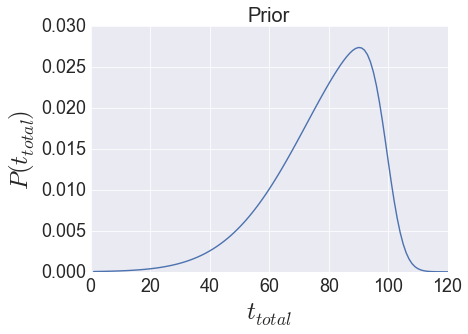

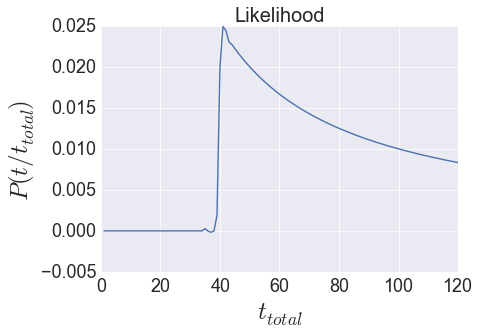

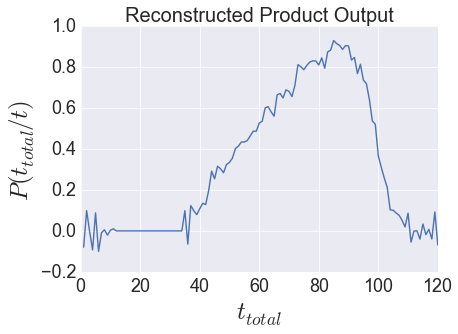

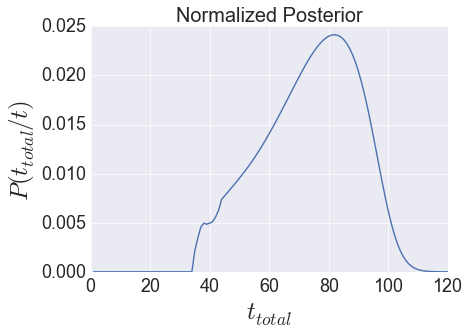

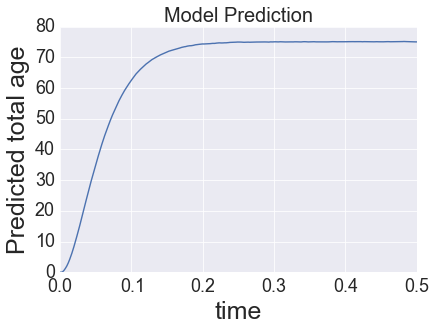

In [62]:
plt.figure()
plt.plot(thetas, space.reconstruct(sim.data[probe_func][-1]))
plt.title("Prior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)

plt.figure()
plt.plot(thetas, lik_space.reconstruct(sim.data[probe_func2][-1]))
plt.title("Likelihood", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t/t_{total})$", fontsize=25)

#post
plt.figure()
plt.plot(thetas, np.dot((sim.data[probe_product][-1]), k.T))
plt.title("Reconstructed Product Output", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.figure()
plt.plot(thetas, sim.data[probe_func4][-1])
plt.title("Normalized Posterior", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total}/t)$", fontsize=25)

plt.figure()
plt.plot(sim.trange(), sim.data[probe_func5])
plt.title("Model Prediction", fontsize=20)
plt.xlabel("time", fontsize=25)
plt.ylabel("Predicted total age", fontsize=25)

plt.show()

In [63]:
prediction = sim.data[probe_func5][-1]
print prediction

[ 75.04514105]
